In [1]:
#%%
#* Import the code needed
import os
from pathlib import Path
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#%%
#* Define paths
directory_path = Path('../../')

In [3]:
pop = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Population' / 'regression_Population.xlsx',
    index_col=0)

PpD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'PpD' / 'regression_PpD.xlsx',
    index_col=0)

UFApD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'UFApD' / 'regression_UFApD.xlsx',
    index_col=0)

energy_intensity = pd.read_excel(
    directory_path / 'data' / 'cleaned_and_combined_data' / 'Energy_Intensity' / 'Energy_intensity_constants.xlsx',
    index_col=[0,1,2])

TS_cj = pd.read_excel(
    directory_path / 'data' / 'cleaned_and_combined_data' / 'Type_Split' / 'Type_Split_ratios.xlsx',
    index_col=0)

lifetime = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Dwelling_Lifetime' / 'lifetime_regression.xlsx',
    index_col=0)

lifetime_standard_deviation = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Dwelling_Lifetime' / 'lifetime_regression.xlsx',
    index_col=0)

lifetime = lifetime.drop('std_dev', axis=1)
lifetime_standard_deviation = lifetime_standard_deviation.drop('lifetime', axis=1)

lifetime = lifetime.loc[:, 'lifetime'].to_numpy()
lifetime

lifetime_standard_deviation = lifetime_standard_deviation.loc[:, 'std_dev'].to_numpy()

In [4]:
# getting the name of the directory where the this file is present.
current = os.path.dirname(os.path.realpath('this'))
 
# Getting the parent directory name where the current directory is present.
parent = os.path.dirname(current)
#make the UA path
module_path = parent + '/modules'
#append path to options to import from
sys.path.append(module_path)

from dynamic_stock_model import DynamicStockModel

In [5]:
stock_t = np.divide(pop,PpD)

stock_t_SFH = np.multiply(stock_t,TS_cj['SFH_ratio'])
stock_t_TH = np.multiply(stock_t,TS_cj['TH_ratio'])
stock_t_AB = np.multiply(stock_t,TS_cj['AB_ratio'])

C:\Users\grace\AppData\Local\Temp\ipykernel_5704\1861254205.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  stock_t = np.divide(pop,PpD)
C:\Users\grace\AppData\Local\Temp\ipykernel_5704\1861254205.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (e

In [6]:
def stock_model(stock):
    dwellings_stock_driven = DynamicStockModel(t=np.arange(1600, 2051),
                         s=stock_t_SFH['Population'].to_numpy(),
                         lt={'Type': 'Normal', 
                             'Mean': lifetime,
                             'StdDev': lifetime_standard_deviation 
                             }
                        )
    
    dwellings_stock_driven.compute_stock_driven_model(
        NegativeInflowCorrect = True)
    
    inflow_t = dwellings_stock_driven.i

    dwellings_inflow_driven = DynamicStockModel(t=np.arange(1600, 2051),
                    i=inflow_t,
                    lt={'Type': 'Normal', 
                        'Mean': lifetime,
                        'StdDev': lifetime_standard_deviation 
                        }
                    )
    dwellings_inflow_driven.compute_s_c_inflow_driven()

    dwellings_inflow_driven.compute_stock_total()

    dwellings_inflow_driven.compute_o_c_from_s_c()


    return dwellings_inflow_driven.s_c, dwellings_inflow_driven.s, dwellings_stock_driven.i, dwellings_stock_driven.o_c


In [7]:
s_c_SFH, s_SFH, i_SFH, o_SFH = stock_model(stock_t_SFH)
s_c_TH, s_TH, i_TH, o_TH = stock_model(stock_t_TH)
s_c_AB, s_AB, i_AB, o_AB = stock_model(stock_t_AB)

Text(0, 0.5, 'dwellings')

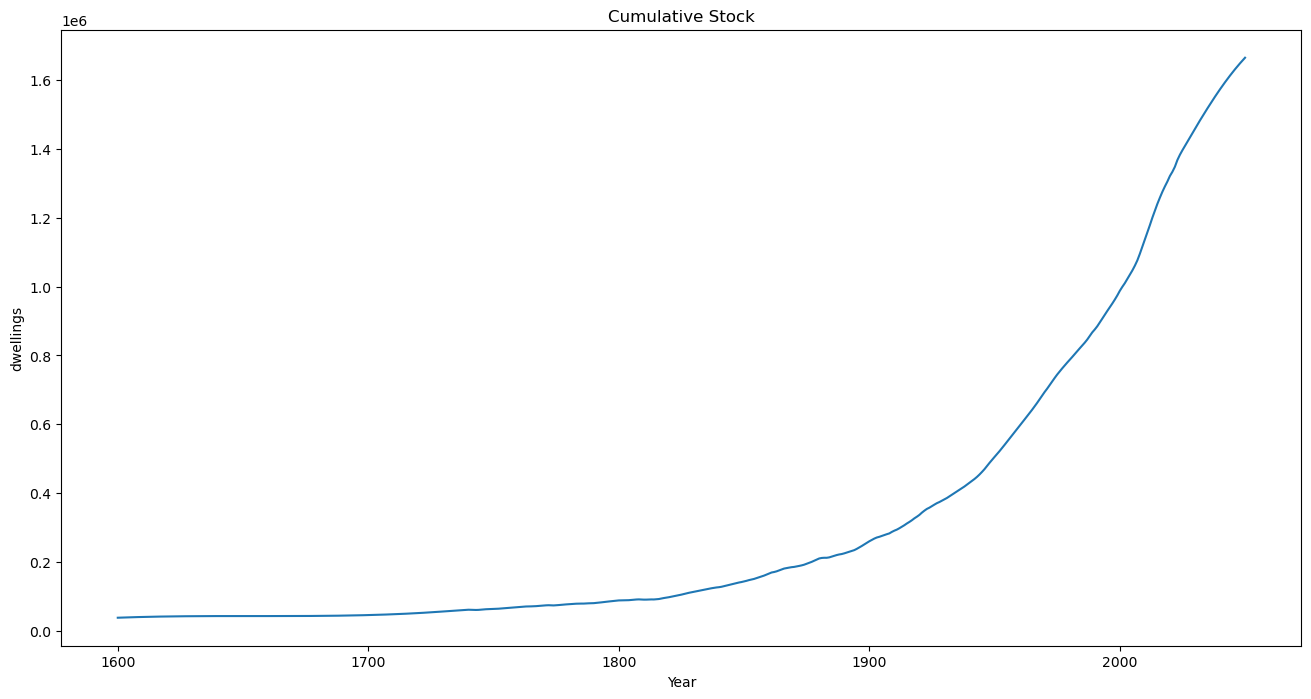

In [8]:
# Plot SFH total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_SFH)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

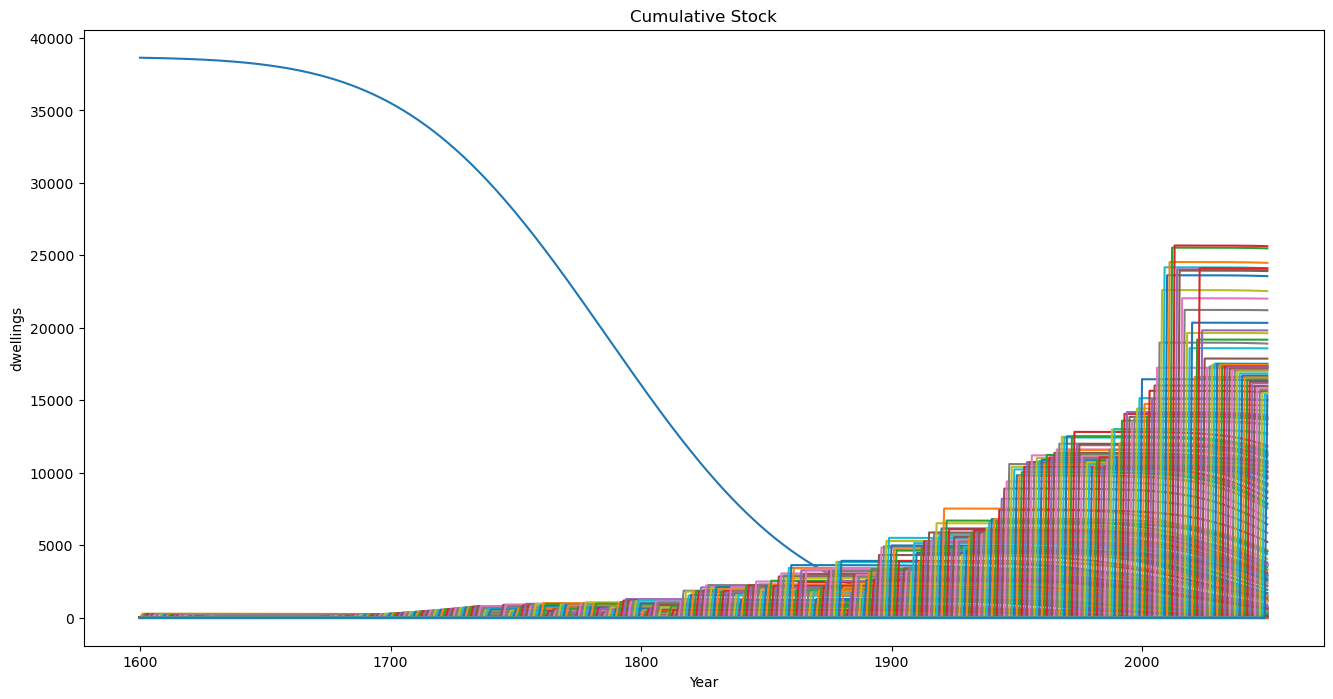

In [9]:
# Plot SFH stock by cohort
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_c_SFH)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

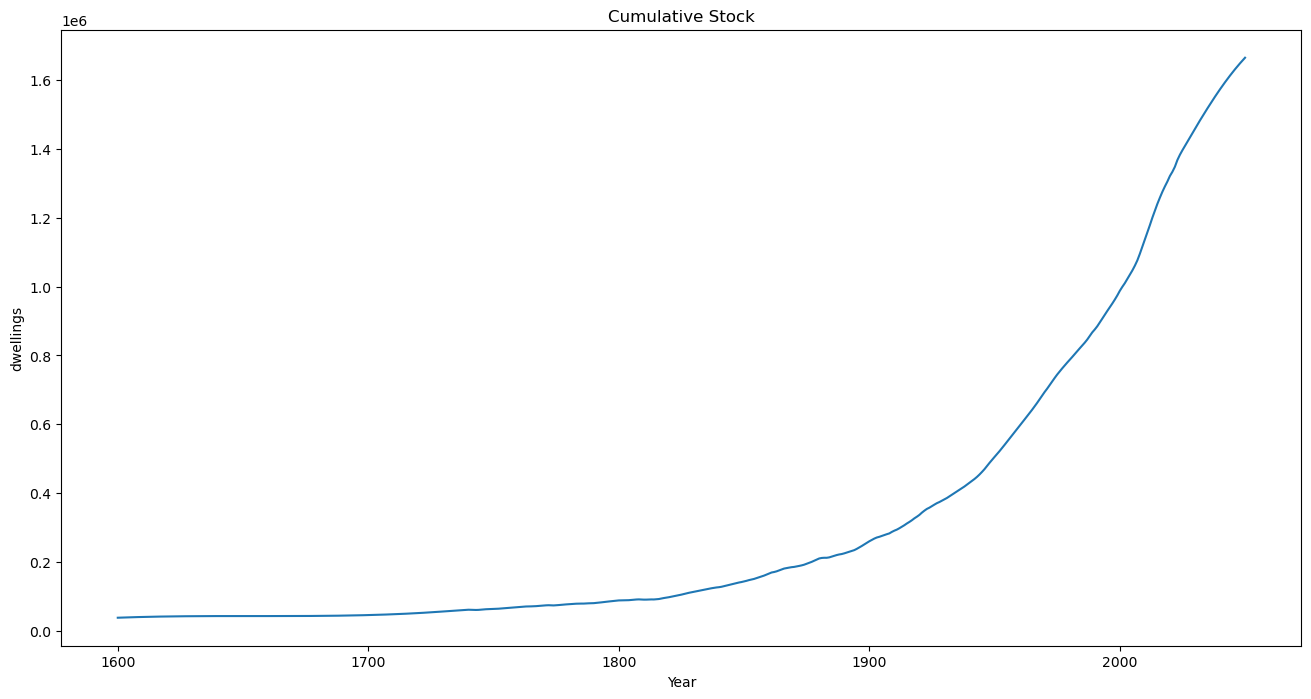

In [10]:
# Plot TH total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_TH)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

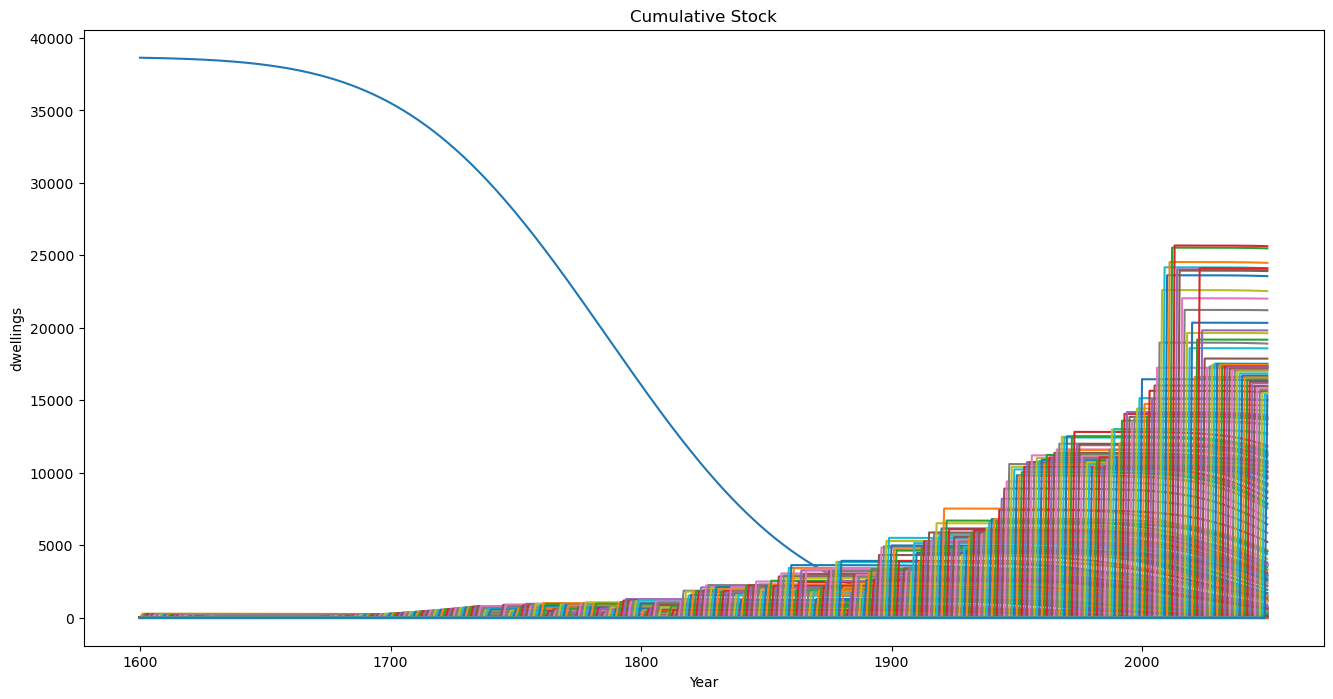

In [11]:
# Plot TH stock by cohort
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_c_TH)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

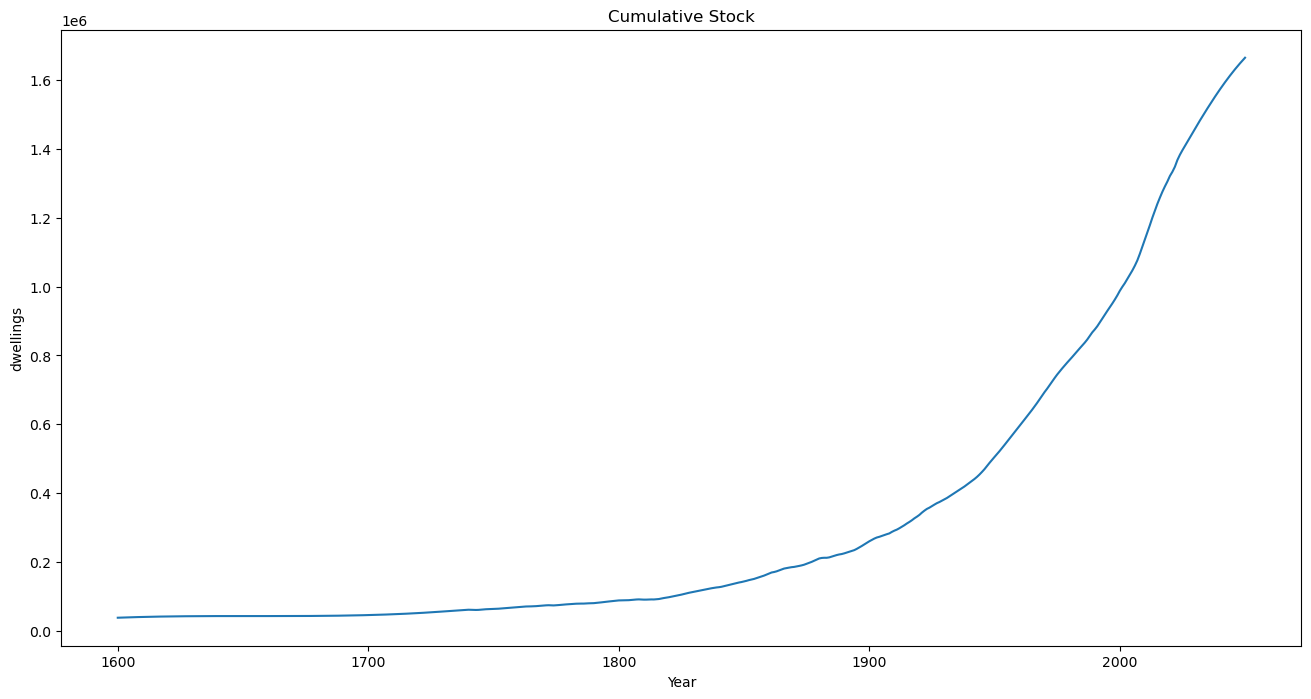

In [12]:
# Plot AB total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_AB)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

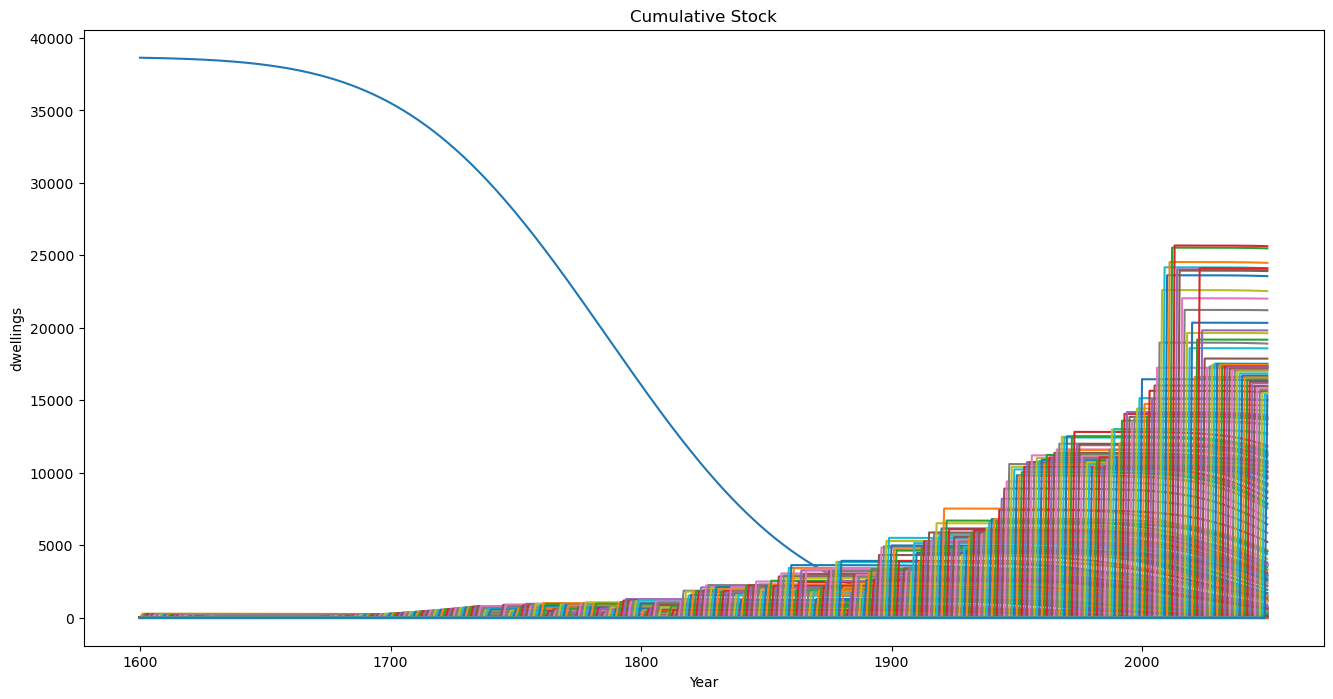

In [13]:
# Plot AB stock by cohort
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_c_AB)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

In [14]:
s_total = s_SFH + s_TH + s_AB

s_c_total = s_c_SFH + s_c_TH + s_c_AB

stock_change_SFH = i_SFH - o_SFH
stock_change_TH = i_TH - o_TH
stock_change_AB = i_AB - o_AB

stock_change_total = stock_change_SFH + stock_change_TH + stock_change_AB

i_total = i_SFH + i_TH + i_AB

o_total = o_SFH + o_TH + o_AB

Text(0, 0.5, 'dwellings')

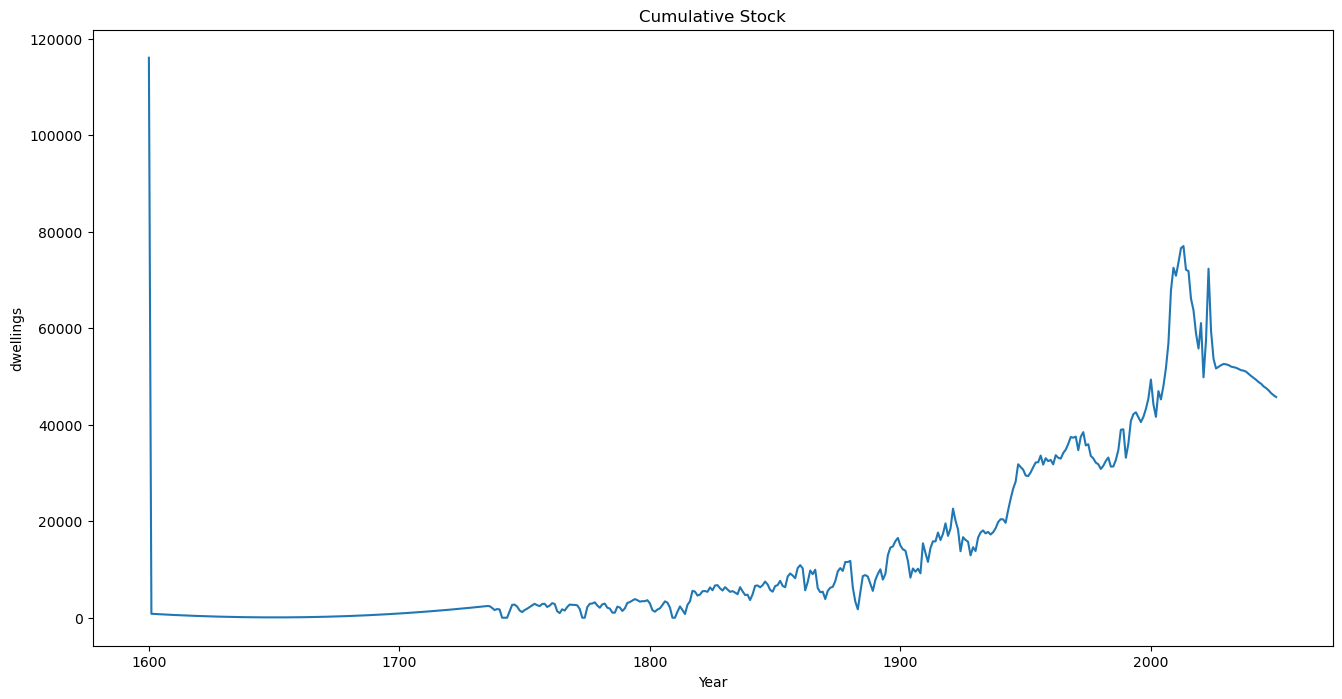

In [15]:
# Plot total inflow
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), i_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

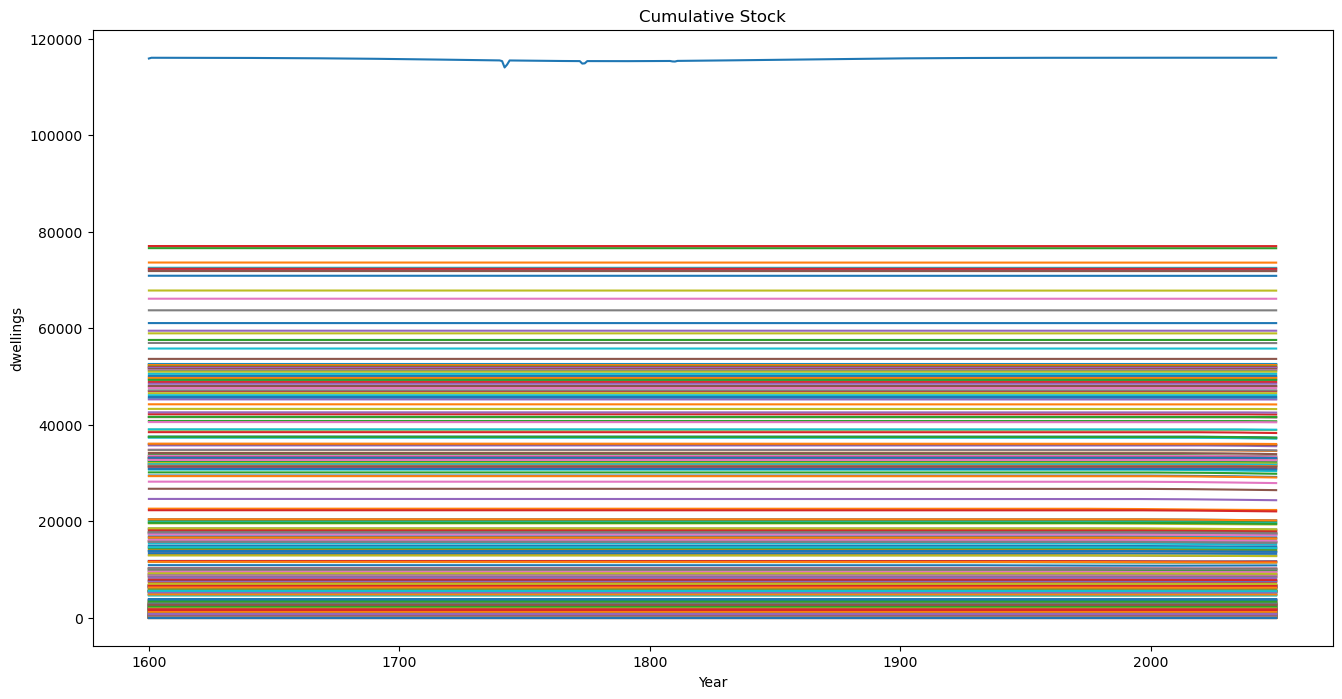

In [16]:
# Plot total stock change
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), stock_change_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

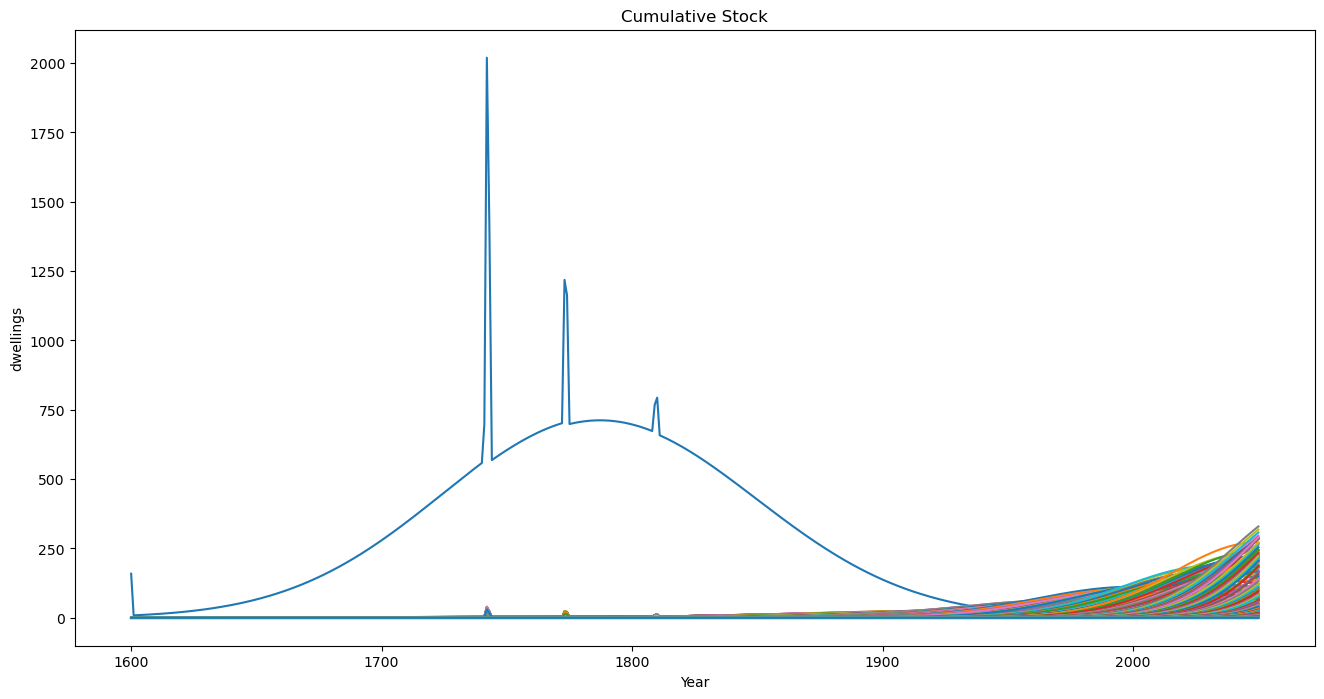

In [17]:
# Plot total outflow
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), o_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

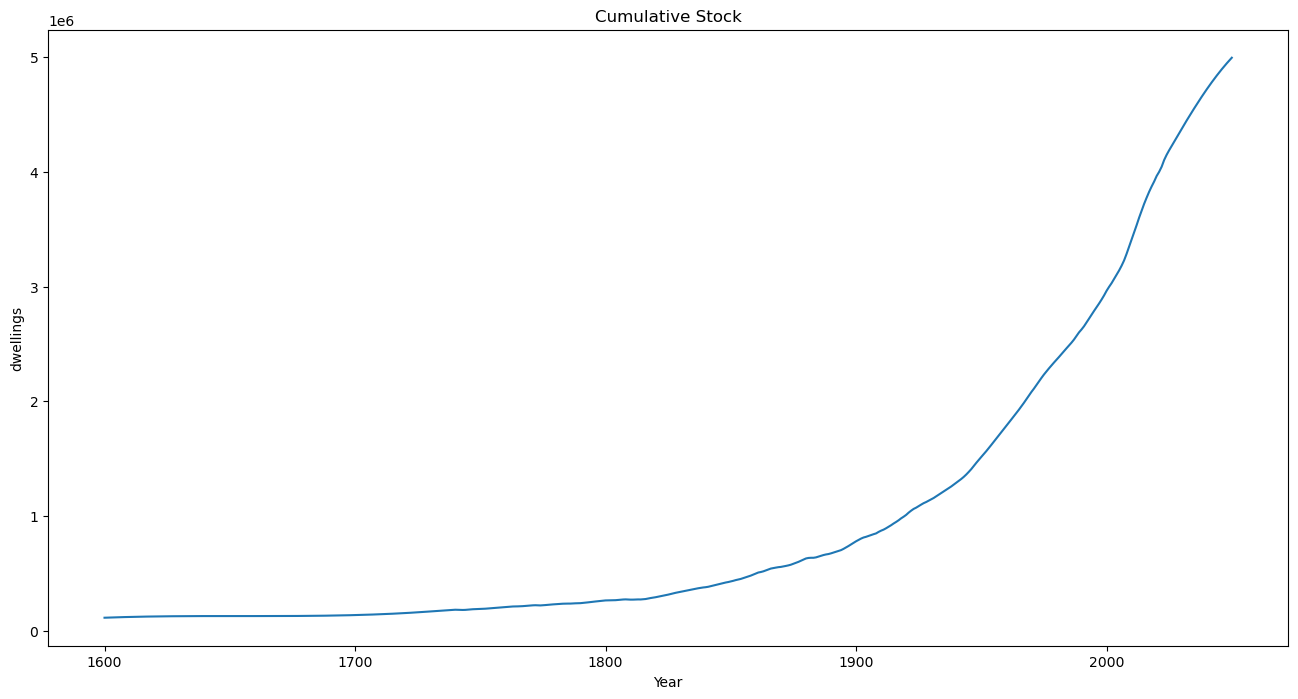

In [18]:
# Plot total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

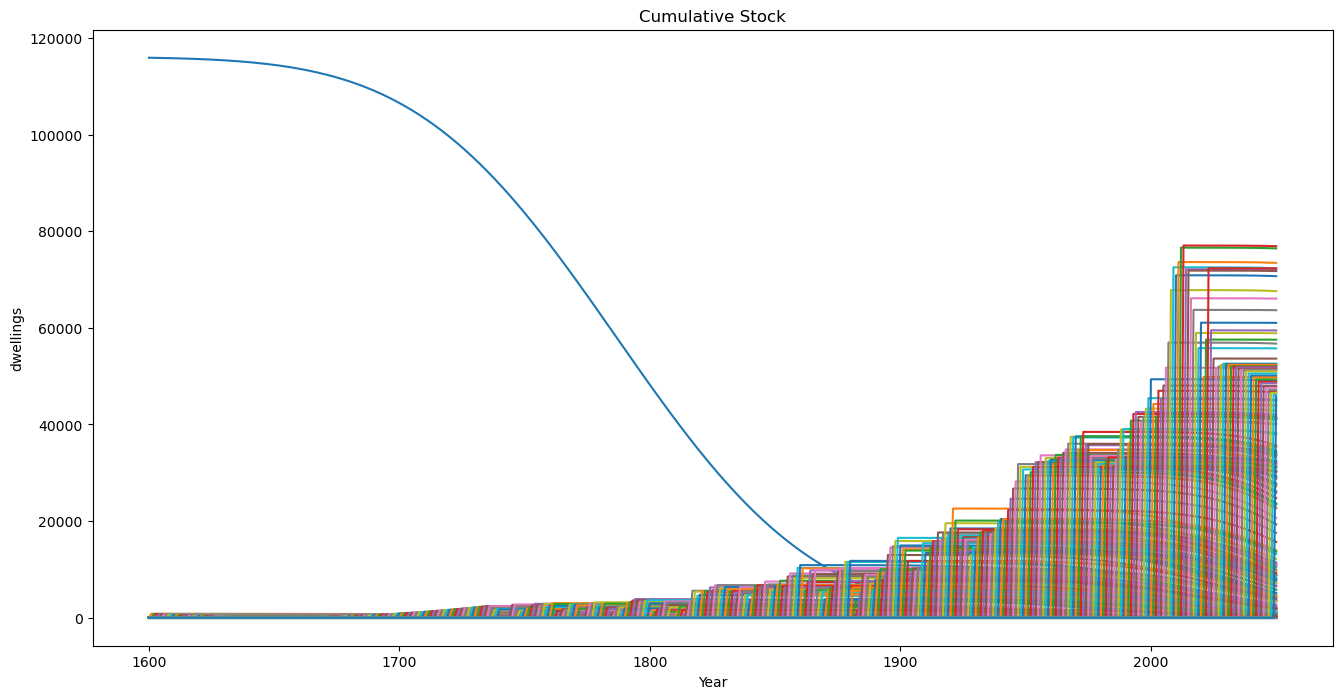

In [19]:
# Plot total stock by cohort
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_c_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

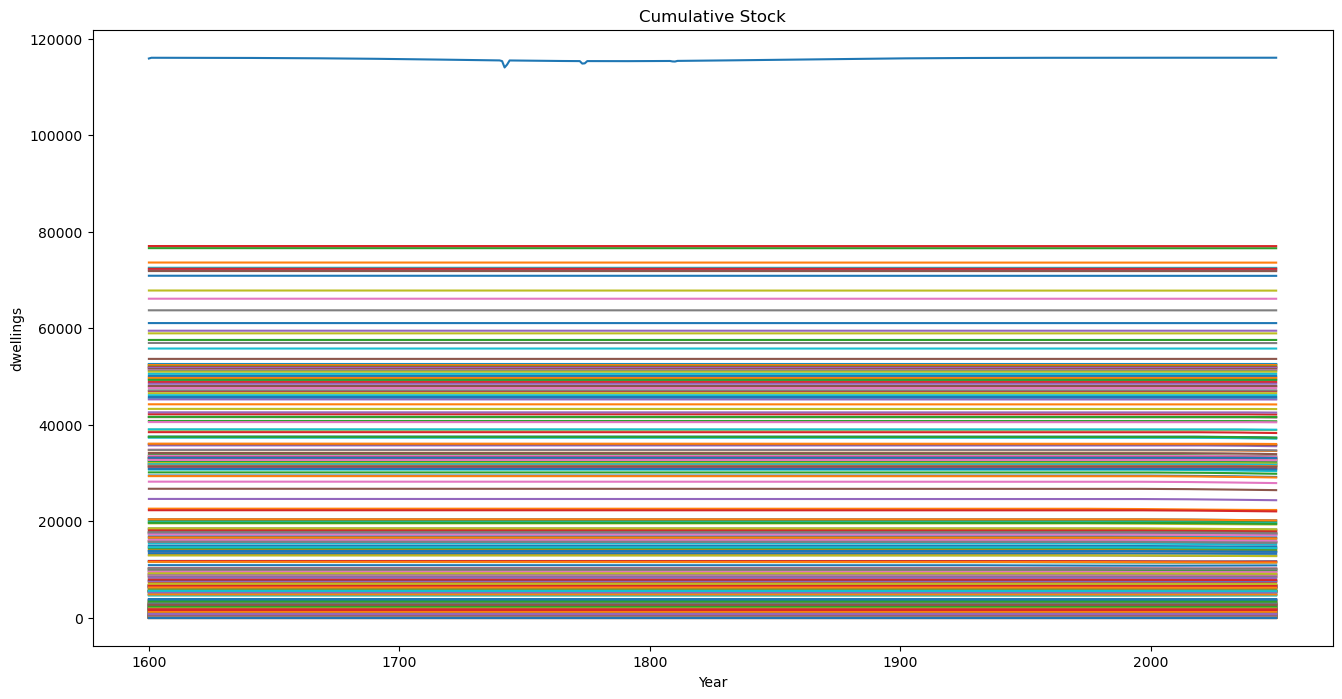

In [20]:
# Plot stock change
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), stock_change_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

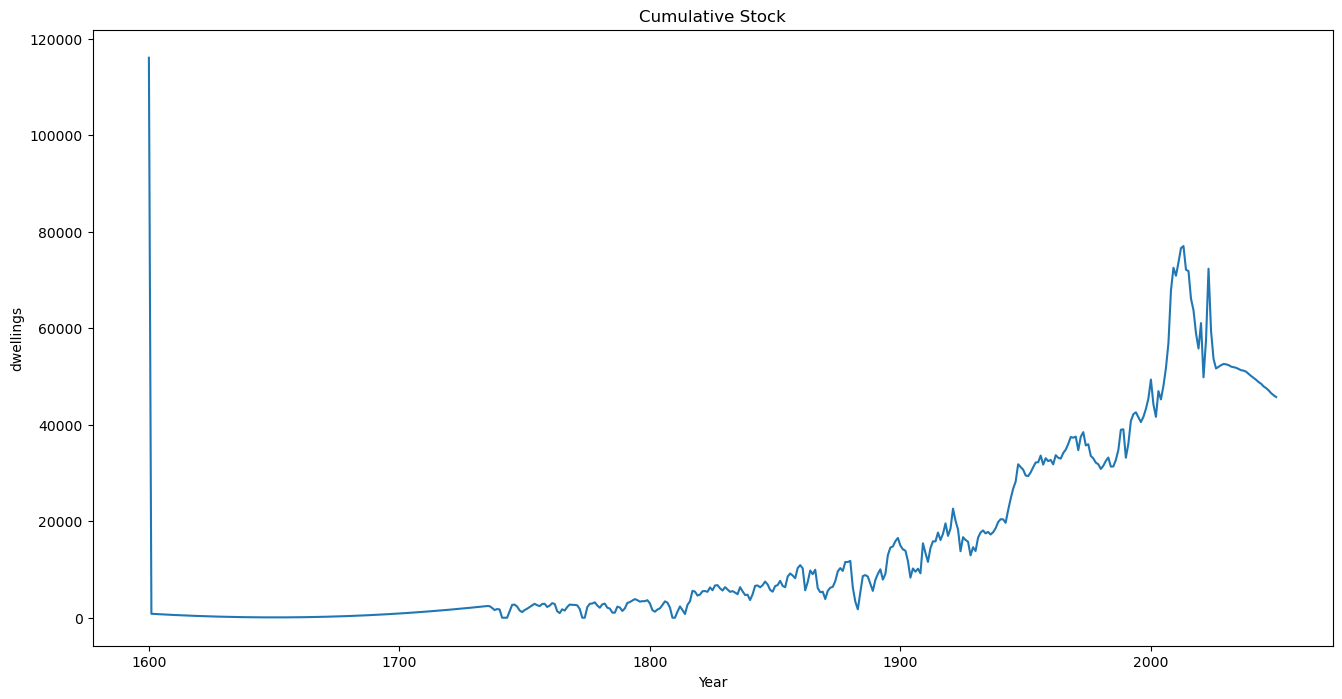

In [21]:
# Plot total inflow
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), i_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Text(0, 0.5, 'dwellings')

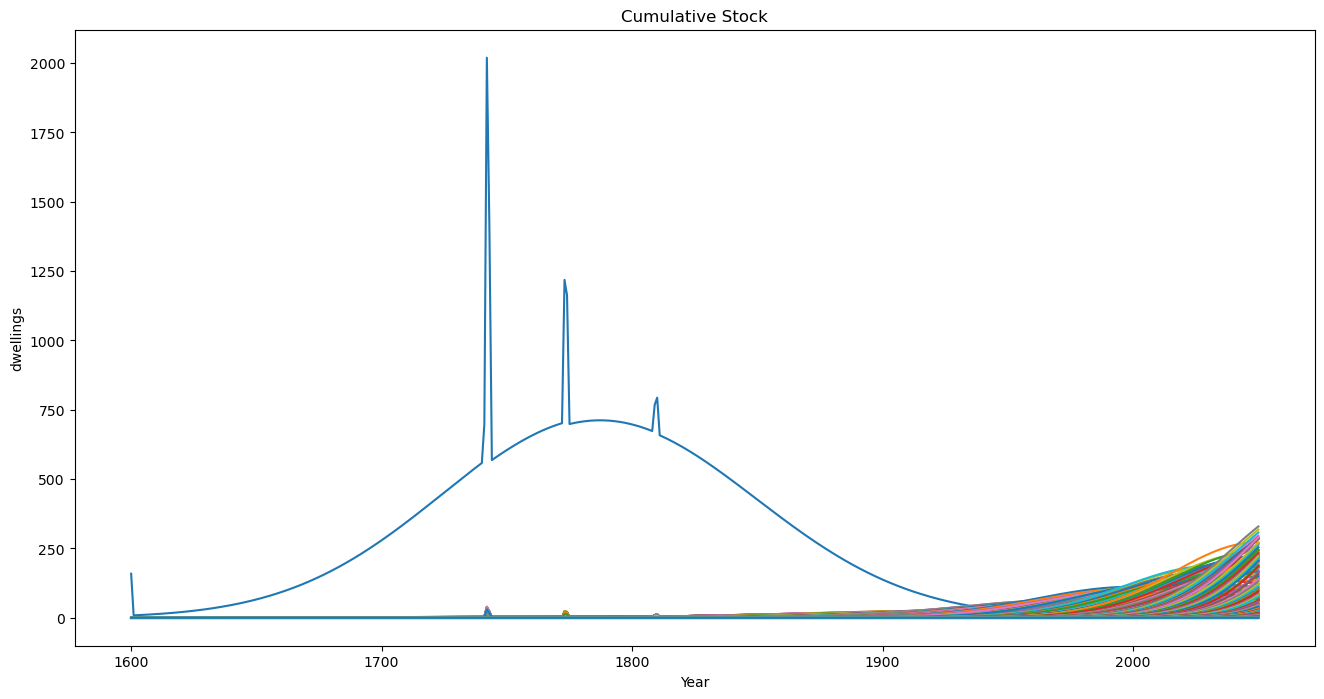

In [22]:
# Plot total outlfow
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), o_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

In [23]:
UFApD.drop_duplicates(inplace=True)

In [24]:
s_c_SFH_df = pd.DataFrame(s_c_SFH)
s_c_SFH_df = s_c_SFH_df.set_index(UFApD.index)
s_c_SFH_df.columns = np.arange(1600, 2051)
s_c_SFH_df

s_c_TH_df = pd.DataFrame(s_c_TH)
s_c_TH_df = s_c_TH_df.set_index(UFApD.index)
s_c_TH_df.columns = np.arange(1600, 2051)
s_c_TH_df

s_c_AB_df = pd.DataFrame(s_c_AB)
s_c_AB_df = s_c_AB_df.set_index(UFApD.index)
s_c_AB_df.columns = np.arange(1600, 2051)
s_c_AB_df

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,38636.277519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,38633.423130,271.614572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,38630.428925,271.594552,261.751249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1603,38627.288865,271.573550,261.732011,252.082009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1604,38623.996693,271.551523,261.711827,252.063534,242.607095,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.610450,0.004425,0.004400,0.004373,0.004340,0.004307,0.004272,0.004232,0.004191,0.004148,...,16564.238056,16435.836069,16279.156716,16164.738894,15978.679437,15860.656796,0.000000,0.000000,0.000000,0.000000
2047,0.568941,0.004124,0.004101,0.004076,0.004045,0.004015,0.003982,0.003944,0.003906,0.003866,...,16564.212461,16435.815386,16279.140256,16164.725708,15978.669028,15860.648525,15706.374230,0.000000,0.000000,0.000000
2048,0.530123,0.003843,0.003821,0.003798,0.003769,0.003741,0.003710,0.003675,0.003640,0.003603,...,16564.181672,16435.790440,16279.120347,16164.709715,15978.656366,15860.638435,15706.366309,15511.484404,0.000000,0.000000


In [25]:
s_UFA_c_SFH = s_c_SFH_df @ np.diag(UFApD['UFApD SFH'])
s_UFA_c_SFH = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH.columns = np.arange(1600, 2051)

s_UFA_c_TH = s_c_TH_df @ np.diag(UFApD['UFApD TH'])
s_UFA_c_TH = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH.columns = np.arange(1600, 2051)

s_UFA_c_AB = s_c_AB_df @ np.diag(UFApD['UFApD AB'])
s_UFA_c_AB = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB.columns = np.arange(1600, 2051)

In [26]:
def energy_use_calculation_SFH(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('pre 1955' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1956-70' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1971-80' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1981-90' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1991-2000' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('2001-2010' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('2011-' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

In [27]:
energy_use_matrix_SFH = energy_use_calculation_SFH(s_UFA_c_SFH)
energy_use_matrix_SFH

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,2.913008e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,2.912793e+09,2.045750e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,2.912567e+09,2.045600e+07,1.969432e+07,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,2.912331e+09,2.045441e+07,1.969287e+07,1.894725e+07,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,2.912082e+09,2.045275e+07,1.969135e+07,1.894586e+07,1.821628e+07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,4.602530e+04,3.332786e+02,3.310692e+02,3.286738e+02,3.258613e+02,323.089029,320.124669,316.744418,313.394275,309.849016,...,2.514194e+08,2.490010e+08,2.461622e+08,2.439702e+08,2.407056e+08,2.384746e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,4.289568e+04,3.106181e+02,3.085615e+02,3.063316e+02,3.037122e+02,301.131160,298.371138,295.222788,292.103286,288.801958,...,2.514191e+08,2.490006e+08,2.461620e+08,2.439700e+08,2.407054e+08,2.384744e+08,2.357061e+08,0.000000e+00,0.000000e+00,0.000000e+00
2048,3.996902e+04,2.894268e+02,2.875127e+02,2.854372e+02,2.829981e+02,280.595506,278.026187,275.094372,272.190173,269.116579,...,2.514186e+08,2.490003e+08,2.461616e+08,2.439698e+08,2.407053e+08,2.384743e+08,2.357060e+08,2.323383e+08,0.000000e+00,0.000000e+00


In [28]:
energy_use_vector_SFH = energy_use_matrix_SFH.sum(axis=1)
energy_use_vector_SFH

Year
1600    2.913008e+09
1601    2.933251e+09
1602    2.952718e+09
1603    2.971425e+09
1604    2.989389e+09
            ...     
2046    4.781624e+10
2047    4.771260e+10
2048    4.760071e+10
2049    4.748137e+10
2050    4.735482e+10
Length: 451, dtype: float64

In [29]:

#* Copy and paste the above 3 blocks of code, change all instances of SFH to TH

In [30]:
def energy_use_calculation_TH(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('pre 1955' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1956-70' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1971-80' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1981-90' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1991-2000' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('2001-2010' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('2011-' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

In [31]:
energy_use_matrix_TH = energy_use_calculation_TH(s_UFA_c_TH)
energy_use_matrix_TH

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,1.456558e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,1.456451e+09,1.023585e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,1.456338e+09,1.023510e+07,9.860476e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,1.456220e+09,1.023431e+07,9.859752e+06,9.492687e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,1.456095e+09,1.023348e+07,9.858991e+06,9.491991e+06,9.132483e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2.301351e+04,1.667550e+02,1.657585e+02,1.646676e+02,1.633661e+02,162.083312,160.702424,159.110871,157.532420,155.853808,...,1.483929e+08,1.471770e+08,1.457090e+08,1.446204e+08,1.428921e+08,1.417733e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,2.144864e+04,1.554169e+02,1.544894e+02,1.534740e+02,1.522620e+02,151.067760,149.782162,148.299867,146.830179,145.267155,...,1.483927e+08,1.471768e+08,1.457089e+08,1.446203e+08,1.428920e+08,1.417733e+08,1.403316e+08,0.000000e+00,0.000000e+00,0.000000e+00
2048,1.998525e+04,1.448139e+02,1.439508e+02,1.430057e+02,1.418773e+02,140.765686,139.569007,138.188718,136.820549,135.365425,...,1.483924e+08,1.471766e+08,1.457087e+08,1.446202e+08,1.428918e+08,1.417732e+08,1.403315e+08,1.385284e+08,0.000000e+00,0.000000e+00


In [32]:
energy_use_vector_TH = energy_use_matrix_TH.sum(axis=1)
energy_use_vector_TH

Year
1600    1.456558e+09
1601    1.466687e+09
1602    1.476433e+09
1603    1.485806e+09
1604    1.494812e+09
            ...     
2046    2.682363e+10
2047    2.675948e+10
2048    2.669110e+10
2049    2.661900e+10
2050    2.654334e+10
Length: 451, dtype: float64

In [33]:

#* Copy and paste the above 3 blocks of code, change all instances of TH to AB

In [34]:
def energy_use_calculation_AB(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('pre 1955' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1956-70' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1971-80' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1981-90' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1991-2000' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('2001-2010' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('2011-' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

In [35]:
energy_use_matrix_AB = energy_use_calculation_AB(s_UFA_c_AB)
energy_use_matrix_AB

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,6.319731e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,6.319264e+08,4.441515e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,6.318775e+08,4.441188e+06,4.278993e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,6.318261e+08,4.440844e+06,4.278678e+06,4.119735e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,6.317722e+08,4.440484e+06,4.278348e+06,4.119433e+06,3.963744e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,9.985125e+03,7.235790e+01,7.193154e+01,7.146414e+01,7.090530e+01,70.354439,69.760920,69.075847,68.396351,67.673252,...,1.072615e+08,1.063948e+08,1.053458e+08,1.045708e+08,1.033329e+08,1.025358e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,9.306157e+03,6.743809e+01,6.704128e+01,6.660623e+01,6.608580e+01,65.572990,65.020434,64.382395,63.749725,63.076423,...,1.072613e+08,1.063947e+08,1.053457e+08,1.045707e+08,1.033329e+08,1.025357e+08,1.015047e+08,0.000000e+00,0.000000e+00,0.000000e+00
2048,8.671222e+03,6.283727e+01,6.246800e+01,6.206312e+01,6.157855e+01,61.101237,60.586904,59.992776,59.403812,58.776995,...,1.072611e+08,1.063945e+08,1.053455e+08,1.045706e+08,1.033328e+08,1.025356e+08,1.015047e+08,1.002121e+08,0.000000e+00,0.000000e+00


In [36]:
energy_use_vector_AB = energy_use_matrix_AB.sum(axis=1)
energy_use_vector_AB

Year
1600    6.319731e+08
1601    6.363680e+08
1602    6.405976e+08
1603    6.446654e+08
1604    6.485743e+08
            ...     
2046    1.559909e+10
2047    1.560138e+10
2048    1.560091e+10
2049    1.559801e+10
2050    1.559279e+10
Length: 451, dtype: float64

# 3D PLOT STOCK OVER TIME BY TYPE AND COHORT

# 3D PLOT INFLOW OVER TIME BY TYPE AND COHORT

# 3D PLOT ENERGY USE OVER TIME BY TYPE AND COHORT

3D plot 1:

UFA by COHORT over TIME

In [37]:
s_UFA_c_total = s_UFA_c_SFH + s_UFA_c_TH + s_UFA_c_AB

s_UFA_c_total


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,2.076070e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,2.075917e+07,145837.176091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,2.075756e+07,145826.427149,140433.963553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,2.075587e+07,145815.150688,140423.642233,135142.889040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,2.075410e+07,145803.323874,140412.813380,135132.984905,129963.844089,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,3.280174e+02,2.375872,2.360750,2.344294,2.324854,2.305692,2.285150,2.261628,2.238309,2.213585,...,5.905295e+06,5.852779e+06,5.790311e+06,5.742985e+06,5.670330e+06,5.621944e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,3.057129e+02,2.214330,2.200254,2.184936,2.166832,2.148992,2.129866,2.107958,2.086246,2.063223,...,5.905286e+06,5.852772e+06,5.790305e+06,5.742981e+06,5.670327e+06,5.621941e+06,5.560817e+06,0.000000e+00,0.000000e+00,0.000000e+00
2048,2.848549e+02,2.063262,2.050162,2.035905,2.019047,2.002442,1.984638,1.964237,1.944023,1.922589,...,5.905275e+06,5.852763e+06,5.790298e+06,5.742975e+06,5.670322e+06,5.621938e+06,5.560815e+06,5.485457e+06,0.000000e+00,0.000000e+00


In [38]:
UFA_total = s_UFA_c_total.sum(axis=1)
UFA_total

Year
1600    2.076070e+07
1601    2.090500e+07
1602    2.104382e+07
1603    2.117725e+07
1604    2.130541e+07
            ...     
2046    6.126641e+08
2047    6.154560e+08
2048    6.181277e+08
2049    6.206982e+08
2050    6.231724e+08
Length: 451, dtype: float64

Text(0, 0.5, 'dwellings')

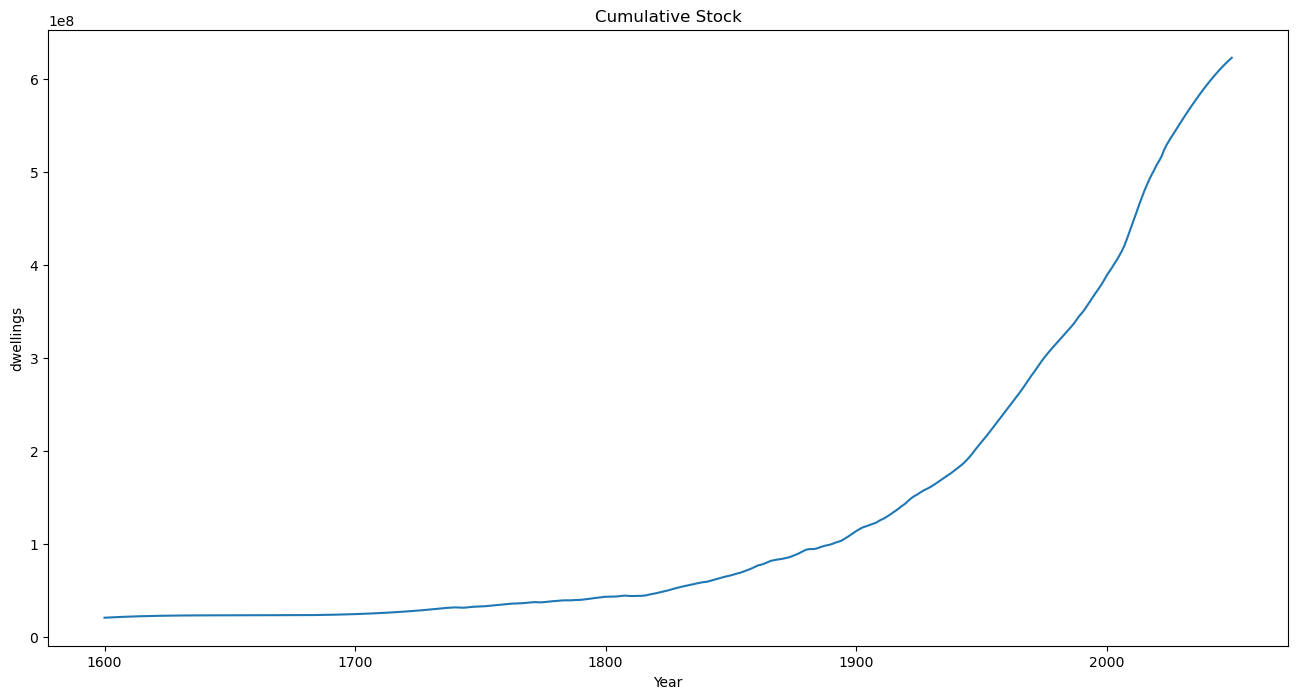

In [39]:
# Plot total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), UFA_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

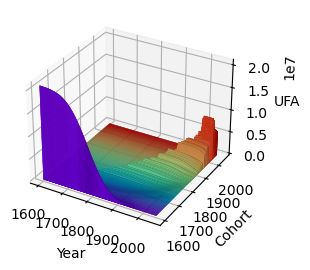

In [40]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')

x = s_UFA_c_total.index
y = s_UFA_c_total.columns
xx, yy = np.meshgrid(x, y)

xx = xx.flatten()
yy = yy.flatten()
zz = np.zeros(451 * 451)

d_x = np.ones(451 * 451)
d_y = np.ones(451 * 451)

s_UFA_c_total_np = s_UFA_c_total.to_numpy()

d_z = s_UFA_c_total_np.transpose().flatten()

colors = plt.cm.rainbow(np.tile(y-1600, (451,1)).transpose().flatten()/451)

ax1.bar3d(xx, yy, zz, d_x, d_y, d_z, shade=True, color=colors)
ax1.set_xlabel('Year')
ax1.set_ylabel('Cohort')
ax1.set_zlabel('UFA')

plt.show()

In [41]:
#* Energy

energy_use_matrix_SFH
energy_use_matrix_TH
energy_use_matrix_AB



,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,6.319731e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,6.319264e+08,4.441515e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,6.318775e+08,4.441188e+06,4.278993e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,6.318261e+08,4.440844e+06,4.278678e+06,4.119735e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,6.317722e+08,4.440484e+06,4.278348e+06,4.119433e+06,3.963744e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,9.985125e+03,7.235790e+01,7.193154e+01,7.146414e+01,7.090530e+01,70.354439,69.760920,69.075847,68.396351,67.673252,...,1.072615e+08,1.063948e+08,1.053458e+08,1.045708e+08,1.033329e+08,1.025358e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,9.306157e+03,6.743809e+01,6.704128e+01,6.660623e+01,6.608580e+01,65.572990,65.020434,64.382395,63.749725,63.076423,...,1.072613e+08,1.063947e+08,1.053457e+08,1.045707e+08,1.033329e+08,1.025357e+08,1.015047e+08,0.000000e+00,0.000000e+00,0.000000e+00
2048,8.671222e+03,6.283727e+01,6.246800e+01,6.206312e+01,6.157855e+01,61.101237,60.586904,59.992776,59.403812,58.776995,...,1.072611e+08,1.063945e+08,1.053455e+08,1.045706e+08,1.033328e+08,1.025356e+08,1.015047e+08,1.002121e+08,0.000000e+00,0.000000e+00
